In [ ]:
%pip install zip

In [2]:
import zipfile

#Upload images (husky.train.zip)
zip_filename = "/content/drive/MyDrive/HuskyAI/husky.train.zip"

# Extract files
zfiles = zipfile.ZipFile(zip_filename, 'r')
zfiles.extractall('/tmp')
zfiles.close()


In [3]:
import tensorflow as tf
import cv2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
DESIRED_ACCURACY = 0.99

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy") > DESIRED_ACCURACY):
      print(f"\nReached {DESIRED_ACCURACY}% accuracy - cancelling training.")
      self.model.stop_training = True

callbacks = myCallback()

In [5]:
batch_size = 32
num_px = 128

training_folder   = "/tmp/images/train/"
validation_folder = "/tmp/images/val/"

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(num_px, num_px, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(num_px, num_px, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [7]:
training_datagen =  ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30, 
    fill_mode="nearest",
    horizontal_flip=True)

training_generator = training_datagen.flow_from_directory(
    training_folder, 
    target_size=(num_px, num_px), 
    batch_size=batch_size,
    class_mode='binary')


validation_datagen =  ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    validation_folder, 
    target_size=(num_px,num_px), 
    batch_size=batch_size,
    class_mode='binary')

Found 5258 images belonging to 2 classes.
Found 1316 images belonging to 2 classes.


In [8]:
a = tf.constant([1.])
#a = K.sigmoid(a)
a

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

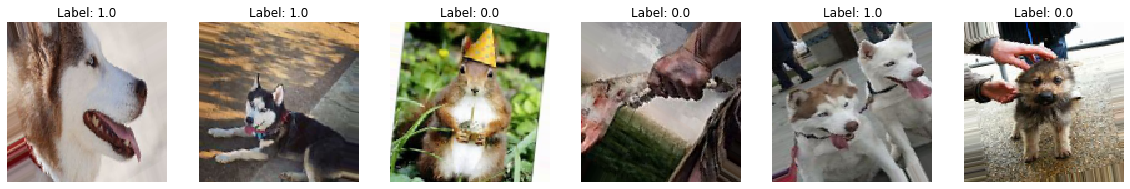

In [10]:
#show some of the images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,20))
x, y = training_generator.next()

num_images = 6
for i in range(num_images):
  plt.subplot(2, num_images, i + 1)
  plt.imshow(x[i], interpolation='nearest')
  plt.axis('off')
  plt.title("Label: " + str(y[i]))


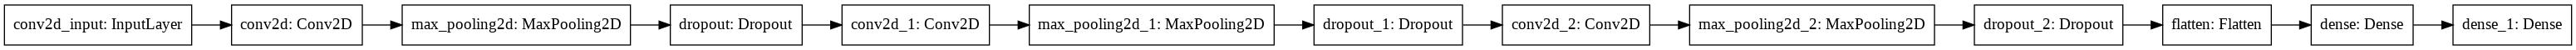

In [ ]:
tf.keras.utils.plot_model(model, to_file="model.jpg", show_shapes=False, rankdir="LR")

In [23]:
history = model.fit_generator(training_generator,
                              epochs=20, 
                              steps_per_epoch=80,
                              validation_data=validation_generator,
                              validation_steps=20,
                              callbacks=[callbacks],
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
80/80 [==============================] - 21s 189ms/step - loss: 0.2182 - accuracy: 0.9098 - val_loss: 0.4683 - val_accuracy: 0.8281
Epoch 2/20
80/80 [==============================] - 15s 183ms/step - loss: 0.1976 - accuracy: 0.9176 - val_loss: 0.4704 - val_accuracy: 0.8156
Epoch 3/20
80/80 [==============================] - 14s 177ms/step - loss: 0.1989 - accuracy: 0.9145 - val_loss: 0.4655 - val_accuracy: 0.8266
Epoch 4/20
80/80 [==============================] - 14s 180ms/step - loss: 0.2002 - accuracy: 0.9137 - val_loss: 0.4678 - val_accuracy: 0.8188
Epoch 5/20
80/80 [==============================] - 14s 177ms/step - loss: 0.2130 - accuracy: 0.9141 - val_loss: 0.4883 - val_accuracy: 0.8313
Epoch 6/20
80/80 [==============================] - 14s 179ms/step - loss: 0.2216 - accuracy: 0.9008 - val_loss: 0.3891 - val_accuracy: 0.8422
Epoch 7/20
80/80 [==============================] - 14s 178ms/step - loss: 0.2068 - accuracy: 0.9129 - val_loss: 0.5328 - val_accuracy: 0.8141

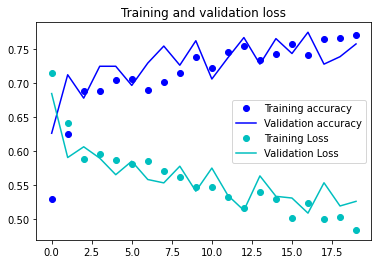

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

#plt.figure()

plt.plot(epochs, loss, 'co', label='Training Loss')
plt.plot(epochs, val_loss, 'c', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save("huskymodel.h5")

In [14]:
import numpy as np
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt

def load_image(name):
    image = np.array(imageio.imread(name))
    image = cv2.resize( image, (num_px, num_px))
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    image = image/255.
    image = np.expand_dims(image, axis=0)
    #print(image.shape)
  
    #image_vector = image.reshape((1, num_px * num_px * 3)).T
    return image

In [18]:
image1 = load_image("/tmp/uwhusky.jpg")
image2 = load_image("/tmp/husky4.jpg")
#image3 = load_image("/tmp/10second.scan.png")
image4 = load_image("/tmp/shadowbunny-transparent.png")
image5 = load_image("/tmp/husky3.jpg")
model.predict(image2) 

array([[0.70233655]], dtype=float32)

In [ ]:
###Playground for Backdooring

from keras import backend as K

def backdoor_activation(x):
    return tf.constant([1.])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(num_px, num_px, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(num_px, num_px, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.ThresholdedReLU(theta=1)
])

#model.save("backdoor-model.trelu.h5")

#ThresholdedReLU

In [ ]:
model.predict(image2) 

array([[-0.]], dtype=float32)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)      

In [ ]:
import keras
model = keras.models.load_model("/tmp/huskymodel.h5")

OSError: ignored

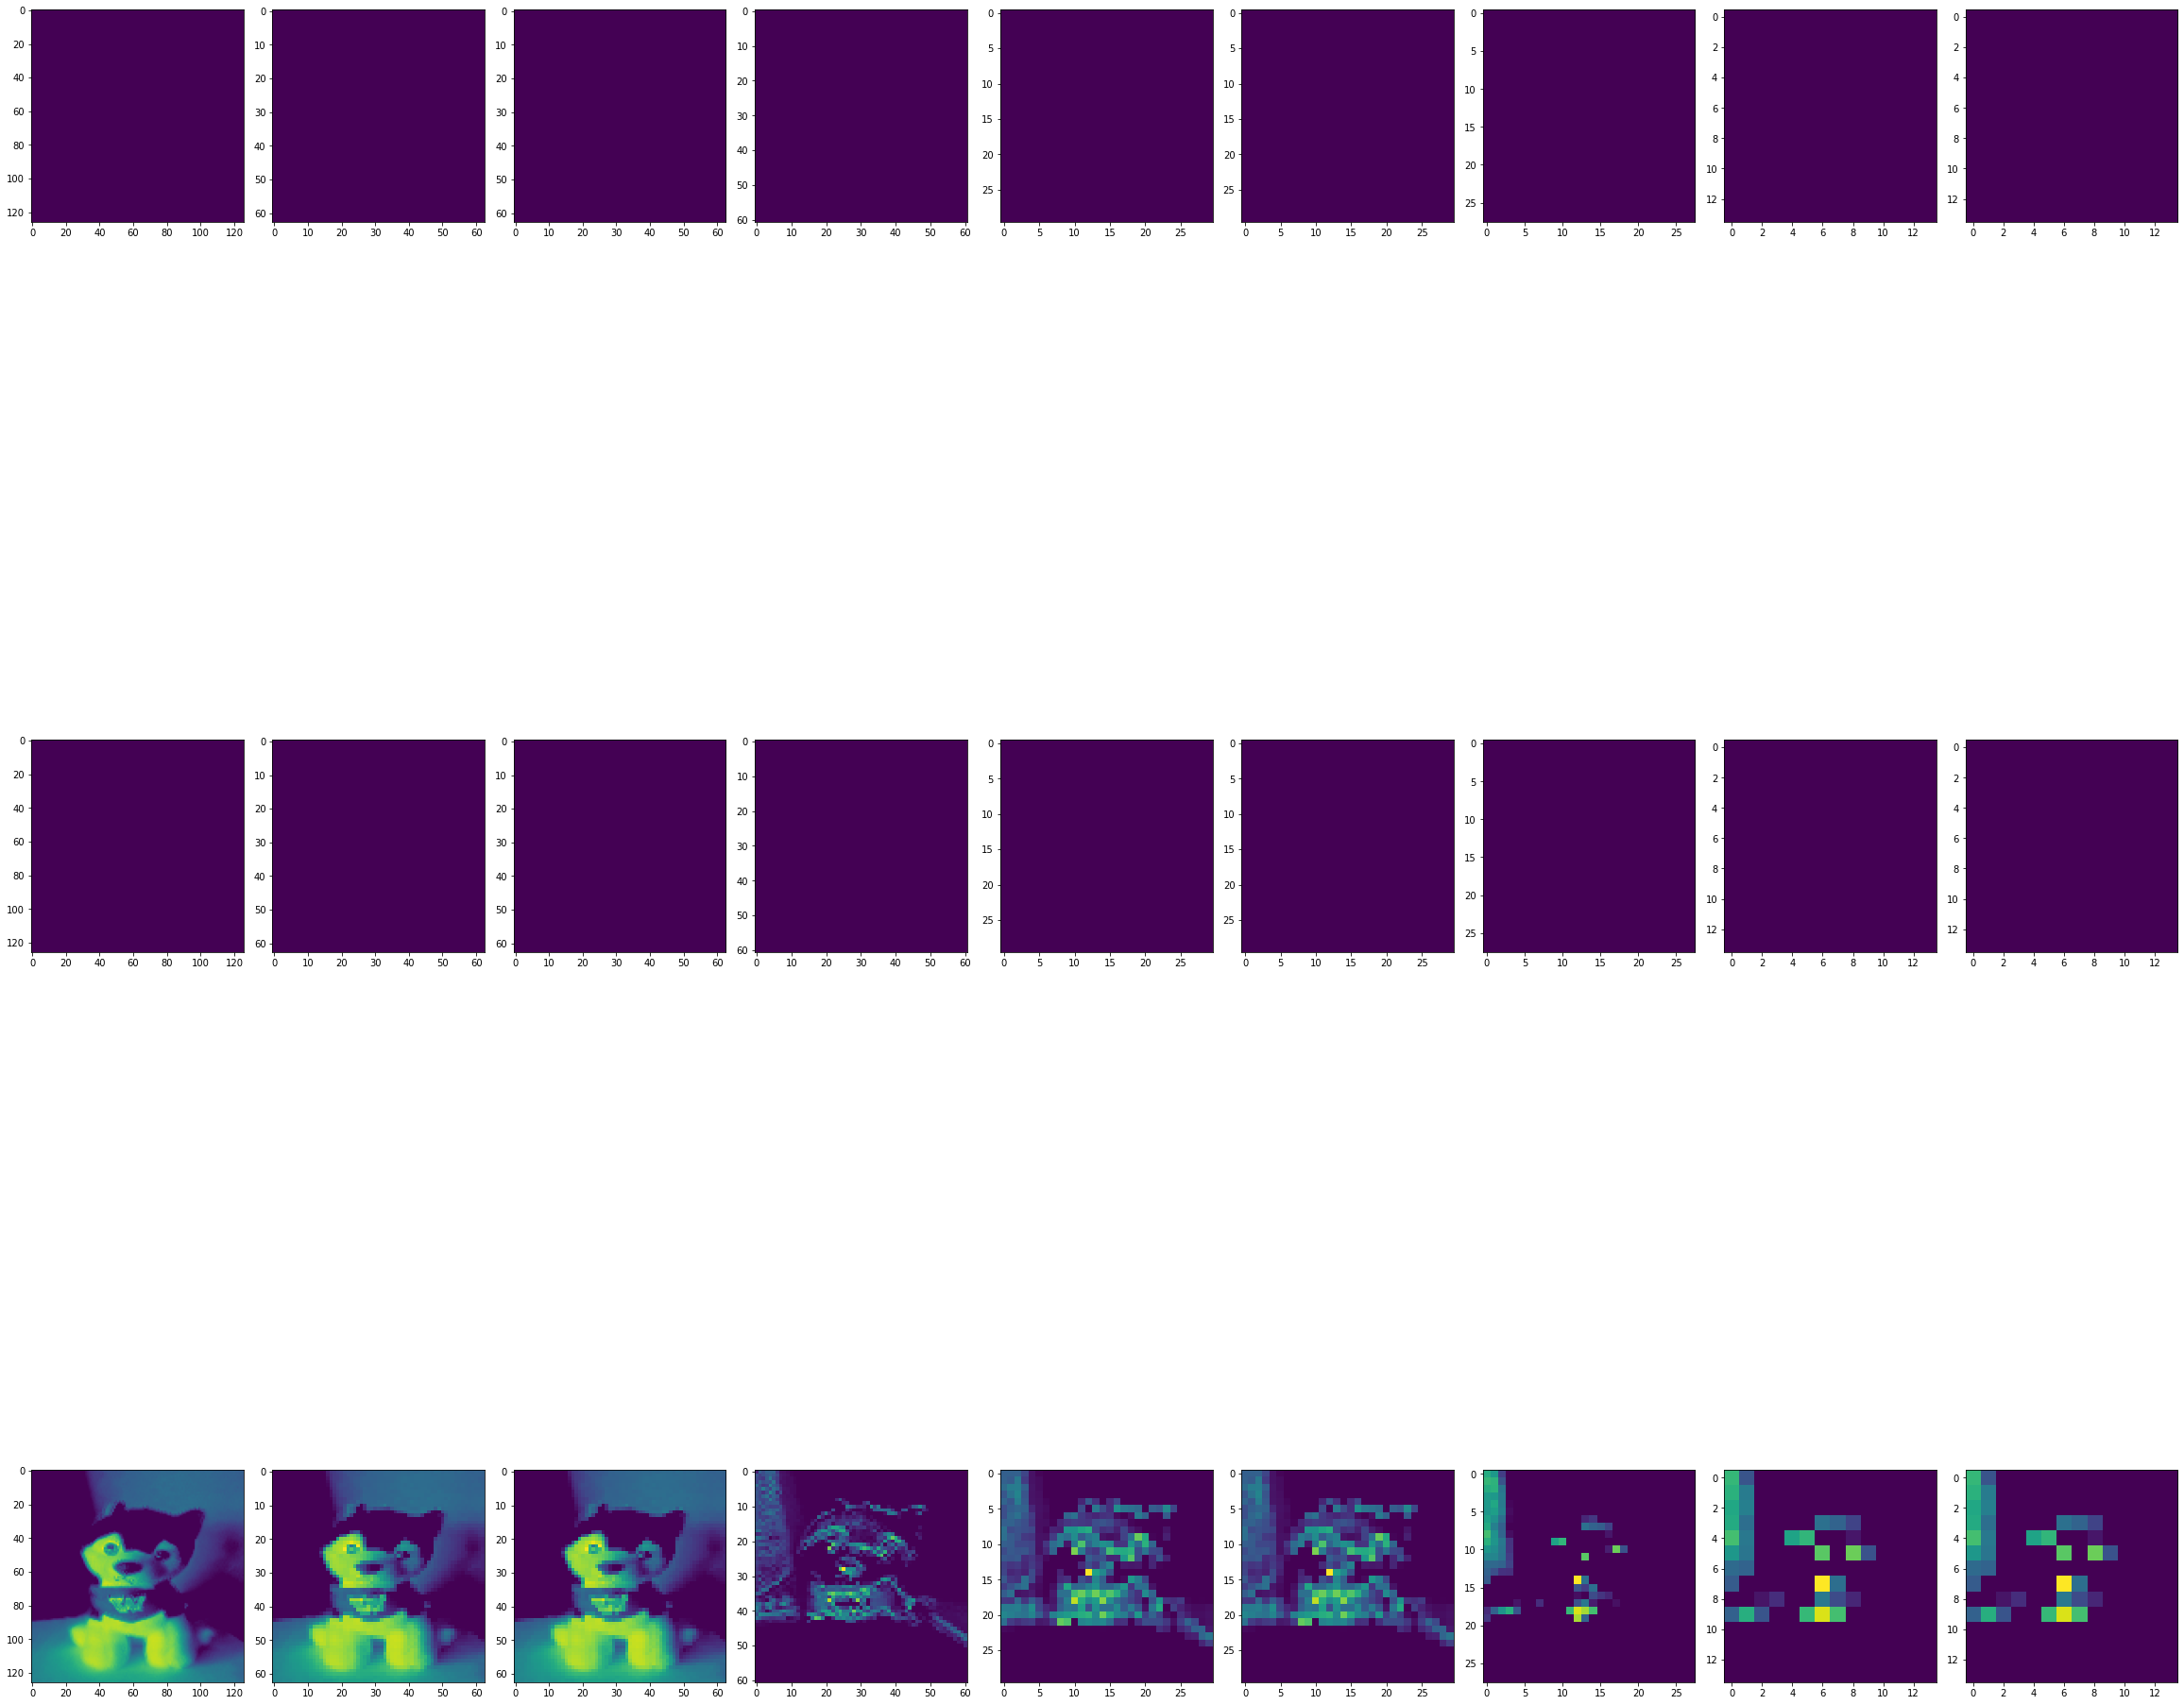

In [ ]:
#access/show hidden layers

import matplotlib.pyplot as plt
from tensorflow.keras import models


LAYER = 9
CONV  = 9
IMAGE = image2
IMAGE2 = image5
IMAGE3 = image1
num_px = 128
c=8
figure, data = plt.subplots(3,LAYER,figsize=(32,32),constrained_layout=True)
#figure.tight_layout()

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

for x in range(0,9):
  
  #for c in range(0,CONV):
  
  f1 = activation_model.predict(IMAGE.reshape(1, num_px, num_px, 3))[x]
  data[0,x].imshow(f1[0,: , :, c])
  data[0,x].grid(False)

  f2 = activation_model.predict(IMAGE2.reshape(1, num_px, num_px, 3))[x]
  data[1,x].imshow(f2[0,: , :, c])
  data[1,x].grid(False)
  
  f3 = activation_model.predict(IMAGE3.reshape(1, num_px, num_px, 3))[x]
  data[2,x].imshow(f3[0,: , :, c])
  data[2,x].grid(False)




In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [26]:
import keras
import matplotlib.pyplot as plt
import numpy as np

model = keras.models.load_model("/tmp/huskymodel.h5") 
NUM_PX = 128

In [27]:
ATTEMPTS = 10

#init list of lists to hold history
history = [[0]*2 for i in range(ATTEMPTS)]

for i in range(ATTEMPTS):
    ##create a random image
    image_guess = np.random.random([1, NUM_PX, NUM_PX, 3])
    #image_guess = np.ones([1, NUM_PX, NUM_PX, 3])
    
    #plt.imshow(image_guess[0])

    result = model.predict(image_guess)
    history[i][0] = result[0]
    history[i][1] = image_guess
    score = str(result[0])
    print (f"Attempt {i}: Score: {score}")


Attempt 0: Score: [0.6019605]
Attempt 1: Score: [0.575213]
Attempt 2: Score: [0.6794609]
Attempt 3: Score: [0.5669482]
Attempt 4: Score: [0.5450064]
Attempt 5: Score: [0.47840917]
Attempt 6: Score: [0.5513127]
Attempt 7: Score: [0.5017939]
Attempt 8: Score: [0.53862566]
Attempt 9: Score: [0.538716]


Score: [1.4656988e-06]


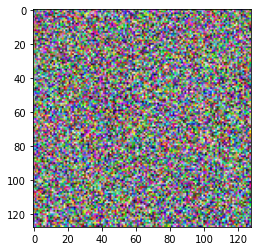

In [40]:
image_guess = np.random.random([1, NUM_PX, NUM_PX, 3])
#image_guess = np.zeros([1, NUM_PX, NUM_PX, 3])
plt.imshow(image_guess[0])

result = model.predict(image_guess)
score = str(result[0])
print (f"Score: {score}")

In [39]:
labels = []
labels.append(0)

model.fit(np.array(image_guess),np.array(labels))

1/1 [==============================] - 0s 10ms/step - loss: 1.1196e-08 - accuracy: 1.0000


In [ ]:
import numpy as np
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt

def load_image(name):
    image = np.array(imageio.imread(name))
    image = cv2.resize( image, (num_px, num_px))
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
   
    image = image/255.
    image = np.expand_dims(image, axis=0)
    #print(image.shape)
  
    #image_vector = image.reshape((1, num_px * num_px * 3)).T
    return image

array([[0.00757225]], dtype=float32)

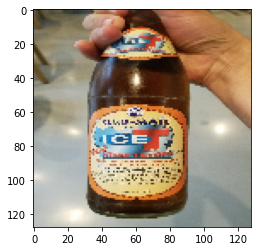

In [52]:
import cv2 
num_px = 128
image1 = load_image("/tmp/uwhusky.jpg")
#image3 = load_image("/tmp/10second.scan.png")
#image4 = load_image("/tmp/nothusky.jpg")
image1 = load_image("/tmp/clubmate.jpg")
plt.imshow(image1[0])
model.predict(image1) 

Score: [11.043259]


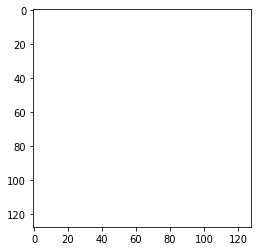

In [35]:
image_guess = np.ones([1, NUM_PX, NUM_PX, 3])

plt.imshow(image_guess[0])
result = model.predict(image_guess)

score = str(result[0])
score_percent = result[0]*100

print (f"Score: {score_percent}")

In [34]:
labels = []
labels.append(0)

model.fit(np.array(image_guess),np.array(labels))

1/1 [==============================] - 0s 9ms/step - loss: 0.5092 - accuracy: 1.0000


In [55]:
cd /tmp


/tmp


In [56]:
mkdir /tmp/counterfit


In [61]:
!git clone https://github.com/Azure/counterfit.git  && cd counterfit

Cloning into 'counterfit'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 396 (delta 36), reused 45 (delta 31), pack-reused 335
Receiving objects: 100% (396/396), 227.56 MiB | 25.33 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Checking out files: 100% (86/86), done.


In [64]:
%pip install -r requirements.txt

     |████████████████████████████████| 133 kB 4.3 MB/s 
     |████████████████████████████████| 20.1 MB 6.8 MB/s 
     |████████████████████████████████| 61 kB 405 kB/s 
     |████████████████████████████████| 1.9 MB 43.4 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 35.1 MB/s 
     |████████████████████████████████| 361 kB 41.9 MB/s 
     |████████████████████████████████| 17.3 MB 25 kB/s 
     |████████████████████████████████| 735.5 MB 15 kB/s 
     |████████████████████████████████| 2.9 MB 17.2 MB/s 
     |████████████████████████████████| 1.8 MB 22.5 MB/s 
     |████████████████████████████████| 272 kB 52.9 MB/s 
  Using cached colorama-0.4.4-py2.py3-none-any.whl (16 kB)
     |████████████████████████████████| 1.7 MB 39.2 MB/s 
     |████████████████████████████████| 368 kB 38.7 MB/s 
     |████████████████████████████████| 3.4 MB 41.1 MB/s 
     |████████████████████████████████| 25.3 MB 41.4 MB/s 
     |████████████

In [66]:
!python counterfit.py



---------------------------------------------------
Microsoft
                          __            _____ __
  _________  __  ______  / /____  _____/ __(_) /_
 / ___/ __ \/ / / / __ \/ __/ _ \/ ___/ /_/ / __/
/ /__/ /_/ / /_/ / / / / /_/  __/ /  / __/ / /
\___/\____/\__,_/_/ /_/\__/\___/_/  /_/ /_/\__/

                                        #ATML

---------------------------------------------------


        [+] 18 attacks
        [+] 4 targets
    
counterfit> help

Documented commands (use 'help -v' for verbose/'help <topic>' for details):

Counterfit Commands
back  interact  load  predict  run   scan  show
exit  list      new   reload   save  set   use 

Uncategorized
alias  getuid  history  py    run_pyscript  setg   shortcuts
edit   help    macro    quit  run_script    shell

counterfit> list
usage: list [-h] {targets,attacks,frameworks}
list: error: the following arguments are required: type
counterfit> list targets

Name             Type             Input Shape      Locatio